In [1]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [2]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_760679.tsv', sep='\t')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,HCT116,A549
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.018,-0.048,0.017,-0.708,NaN
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.043,0.191,0.099,-0.262,NaN
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.005,0.650,-0.185,0.627,NaN
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.762,0.281,0.676,NaN
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.455,-0.643,0.066,-0.164,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.716,1.309,1.089,NaN,NaN
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.544,-0.427,NaN,NaN
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.143,-0.195,-0.308,NaN,NaN
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.116,-0.084,-0.385,NaN,NaN


In [3]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [4]:
data_split_dict = {}

data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test']  = MPRA_df['chr'].isin(['chr2'])

# 和前三种细胞类型差异top5%的序列定义为cell type specific
for cell_type in cell_types:
    ref_mean = MPRA_df[cell_types[:3]].mean(axis=1)
    diff = (MPRA_df[cell_type] - ref_mean).abs()
    threshold = np.percentile(diff.dropna(), 99)
    data_split_dict[f'{cell_type}_specific'] = diff > threshold


for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
train 631073
valid 70952
test 58654
K562_specific 7607
HepG2_specific 7607
SK-N-SH_specific 7607
HCT116_specific 4482
A549_specific 3195


In [5]:
for data_split in ['total', 'test', 'specific', 'test+specific']:
    pearson_df = pd.DataFrame()
    for i, c1 in enumerate(cell_types):
        for j, c2 in enumerate(cell_types):
                if data_split == 'specific':
                    cond = data_split_dict[f'{c1}_specific']
                elif data_split == 'test+specific':
                    cond = data_split_dict[f'{c1}_specific'] & data_split_dict['test']
                else:
                    cond = data_split_dict[data_split]
                pred = MPRA_df.loc[cond, f'{c1}']
                true = MPRA_df.loc[cond, f'{c2}']
                r, _ = pearson(pred, true)
                pearson_df.loc[c1, c2] = r
    print(data_split)
    print(pearson_df)

total
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.801    0.759   0.825 0.724
HepG2   0.801  1.000    0.836   0.879 0.730
SK-N-SH 0.759  0.836    1.000   0.833 0.777
HCT116  0.825  0.879    0.833   1.000 0.825
A549    0.724  0.730    0.777   0.825 1.000
test
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.785    0.745   0.817 0.698
HepG2   0.785  1.000    0.819   0.870 0.712
SK-N-SH 0.745  0.819    1.000   0.819 0.757
HCT116  0.817  0.870    0.819   1.000 0.821
A549    0.698  0.712    0.757   0.821 1.000
specific
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.008   -0.066   0.233 0.039
HepG2   0.035  1.000    0.164   0.471 0.253
SK-N-SH 0.166  0.363    1.000   0.647 0.734
HCT116  0.295  0.481    0.334   1.000 0.535
A549    0.727  0.669    0.789   0.833 1.000
test+specific
          K562  HepG2  SK-N-SH  HCT116   A549
K562     1.000 -0.011   -0.107   0.187 -0.084
HepG2   -0.016  1.000    0.063   0.385  0.225
SK-N-SH  0.174  0.283    1.000   0.6

test
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.785    0.745   0.817 0.698
HepG2   0.785  1.000    0.819   0.870 0.712
SK-N-SH 0.745  0.819    1.000   0.819 0.757
HCT116  0.817  0.870    0.819   1.000   NaN
A549    0.698  0.712    0.757     NaN 1.000


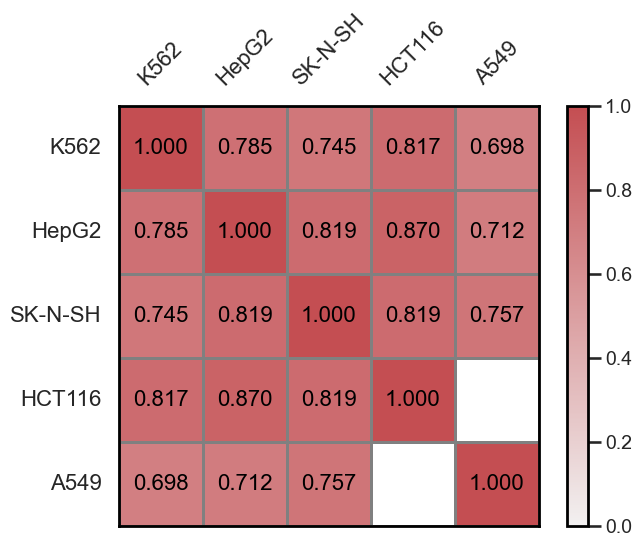

test+specific
          K562  HepG2  SK-N-SH  HCT116   A549
K562     1.000 -0.011   -0.107   0.187 -0.084
HepG2   -0.016  1.000    0.063   0.385  0.225
SK-N-SH  0.174  0.283    1.000   0.611  0.675
HCT116   0.257  0.519    0.326   1.000    NaN
A549     0.624  0.643    0.774     NaN  1.000


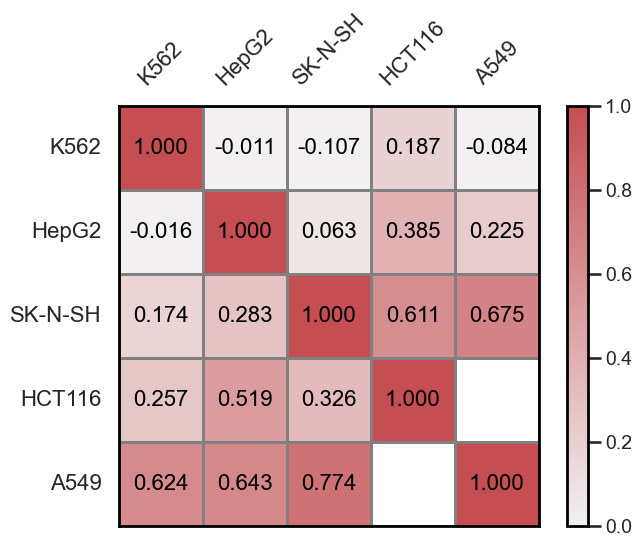

In [6]:
for data_split in ['test', 'test+specific']:
    pearson_df = pd.DataFrame()
    for c1 in cell_types:
        for c2 in cell_types:
            if data_split == 'specific':
                cond = data_split_dict[f'{c1}_specific']
            elif data_split == 'test+specific':
                cond = data_split_dict[f'{c1}_specific'] & data_split_dict['test']
            else:
                cond = data_split_dict[data_split]
            x = MPRA_df.loc[cond, f'{c1}']
            y = MPRA_df.loc[cond, f'{c2}']
            r, p = pearson(x, y)
            pearson_df.loc[f'{c1}', f'{c2}'] = r
    pearson_df.loc['HCT116', 'A549'] = np.nan
    pearson_df.loc['A549', 'HCT116'] = np.nan
    pearson_df = pearson_df.astype(float)
    print(data_split)
    print(pearson_df)



    # === 图形配置 ===
    sns.set_theme(style="white", context="talk")  # 统一风格
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8)

    # === 热图绘制 ===
    sns_plot = sns.heatmap(
        pearson_df,
        cmap=sns.color_palette("light:r", as_cmap=True),
        vmin=0.0,
        vmax=1.0,
        square=True,
        annot=True,
        fmt=".3f",
        annot_kws={"size": 16, "color": "black"},
        cbar=True,
        linewidths=1,
        linecolor="gray",
        ax=ax
    )

    # === 坐标轴美化 ===
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.tick_params(axis="x", top=False, bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, rotation=0)

    # === 边框设置 ===
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor("black")

    # === 色条（colorbar）设置 ===
    cbar = sns_plot.collections[0].colorbar
    cbar.outline.set_linewidth(2)
    cbar.outline.set_edgecolor("black")
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cbar.ax.tick_params(labelsize=14)

    # === 输出 ===
    plt.savefig(f'figures/Gosai_MPRA_activity_vs_activity_{data_split}_heatmap.png', dpi=400)
    plt.savefig(f'figures_pdf/Gosai_MPRA_activity_vs_activity_{data_split}_heatmap.pdf')
    plt.show()

In [7]:
y_pred = np.load(f'../saved/1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF/1110_135744/Gosai_pred.npy')
# y_pred = np.load(f'../saved/1111_Gosai_MPRA_MyResTrans_seq_AG_VEF/1110_135647/Gosai_pred.npy')

pred_cols = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[pred_cols] = y_pred
MPRA_df.describe()

,pos,K562,HepG2,SK-N-SH,HCT116,A549,K562_pred,HepG2_pred,SK-N-SH_pred,HCT116_pred,A549_pred
count,760679.000,760679.000,760679.000,760679.000,448103.000,319496.000,760679.000,760679.000,760679.000,760679.000,760679.000
mean,75202958.598,-0.000,-0.000,0.000,0.000,-0.000,0.045,0.032,0.035,0.048,0.048
std,57521411.054,1.000,1.000,1.000,1.000,1.000,1.010,0.982,0.991,1.019,1.006
min,14677.000,-5.360,-5.745,-5.762,-5.956,-6.017,-2.741,-3.029,-3.091,-2.811,-2.902
25%,28973267.000,-0.564,-0.597,-0.569,-0.567,-0.504,-0.525,-0.536,-0.526,-0.525,-0.526
50%,62363640.000,-0.283,-0.256,-0.206,-0.272,-0.203,-0.272,-0.260,-0.221,-0.268,-0.257
75%,112600466.000,0.206,0.284,0.285,0.208,0.215,0.187,0.217,0.241,0.204,0.212
max,249200985.000,7.854,7.705,8.315,7.761,11.771,7.877,7.853,7.923,7.827,7.903


test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.841       0.775         0.742        0.795      0.786
HepG2        0.779       0.838         0.784        0.794      0.798
SK-N-SH      0.746       0.771         0.832        0.774      0.777
HCT116       0.799       0.812         0.786        0.813      0.805
A549         0.673       0.683         0.696        0.713      0.720


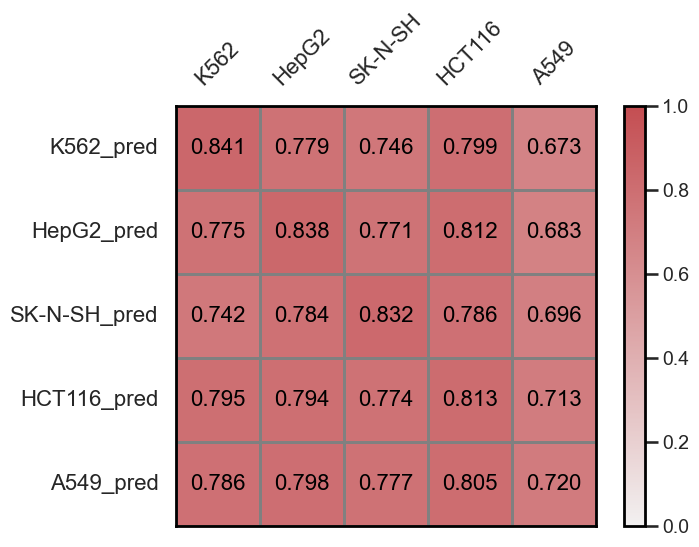

test+specific 281
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.636       0.220         0.063        0.282      0.237
HepG2        0.181       0.624         0.232        0.305      0.414
SK-N-SH      0.303       0.299         0.642        0.451      0.447
HCT116       0.433       0.492         0.410        0.559      0.509
A549         0.661       0.650         0.683        0.740      0.750


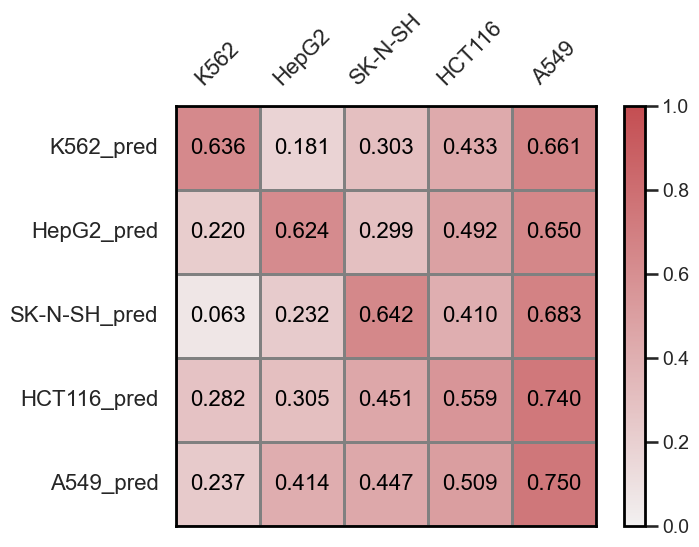

In [9]:
# 预测值和真实值的相关性

for data_split in ['test', 'test+specific']:
    pearson_df = pd.DataFrame()
    for c1 in cell_types:
        for c2 in cell_types:
            if data_split == 'specific':
                cond = data_split_dict[f'{c1}_specific']
            elif data_split == 'test+specific':
                cond = data_split_dict[f'{c1}_specific'] & data_split_dict['test']
            else:
                cond = data_split_dict[data_split]
            x = MPRA_df.loc[cond, f'{c1}']
            y = MPRA_df.loc[cond, f'{c2}_pred']
            r, p = pearson(x, y)
            pearson_df.loc[f'{c1}', f'{c2}_pred'] = r
    print(data_split, len(x))
    print(pearson_df)



    pearson_df = pearson_df.T

    # === 图形配置 ===
    sns.set_theme(style="white", context="talk")  # 统一风格
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8)

    # === 热图绘制 ===
    sns_plot = sns.heatmap(
        pearson_df,
        cmap=sns.color_palette("light:r", as_cmap=True),
        vmin=0.0,
        vmax=1.0,
        square=True,
        annot=True,
        fmt=".3f",
        annot_kws={"size": 16, "color": "black"},
        cbar=True,
        linewidths=1,
        linecolor="gray",
        ax=ax
    )

    # === 坐标轴美化 ===
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.tick_params(axis="x", top=False, bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, rotation=0)

    # === 边框设置 ===
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor("black")

    # === 色条（colorbar）设置 ===
    cbar = sns_plot.collections[0].colorbar
    cbar.outline.set_linewidth(2)
    cbar.outline.set_edgecolor("black")
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cbar.ax.tick_params(labelsize=14)

    # === 输出 ===
    plt.savefig(f'figures/Gosai_MPRA_activity_vs_ExpCast_pred_{data_split}_heatmap.png', dpi=400)
    plt.savefig(f'figures_pdf/Gosai_MPRA_activity_vs_ExpCast_pred_{data_split}_heatmap.pdf', dpi=400)
    plt.show()

In [32]:
# VEF_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_VEF_zscore.tsv', sep='\t')
# VEF_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_AG_VEF_scalelog1pmean1.tsv', sep='\t')
# VEF_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Enformer_VEF_log1p.tsv', sep='\t')
VEF_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Borzoi_VEF_log1p.tsv', sep='\t')
VEF_df.describe()

,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,K562_CAGE,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,HepG2_CAGE,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_CTCF,SK-N-SH_CAGE,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_CTCF,HCT116_CAGE,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_CTCF,A549_CAGE
count,760679.000,760679.000,0.000,760679.000,0.000,760679.000,760679.000,0.000,760679.000,0.000,760679.000,760679.000,760679.000,760679.000,0.000,760679.000,760679.000,760679.000,760679.000,0.000,760679.000,760679.000,0.000,760679.000,0.000
mean,0.048,0.458,NaN,0.617,NaN,0.058,0.406,NaN,0.659,NaN,0.058,0.601,0.502,0.655,NaN,0.046,0.497,0.557,0.660,NaN,0.047,0.252,NaN,0.647,NaN
std,0.068,0.198,NaN,0.302,NaN,0.051,0.158,NaN,0.273,NaN,0.076,0.150,0.273,0.223,NaN,0.049,0.200,0.250,0.250,NaN,0.051,0.160,NaN,0.267,NaN
min,0.001,0.004,NaN,0.003,NaN,0.003,0.006,NaN,0.010,NaN,0.003,0.035,0.008,0.023,NaN,0.003,0.010,0.014,0.013,NaN,0.003,0.001,NaN,0.014,NaN
25%,0.022,0.345,NaN,0.461,NaN,0.031,0.314,NaN,0.500,NaN,0.033,0.534,0.331,0.562,NaN,0.032,0.391,0.443,0.540,NaN,0.026,0.178,NaN,0.503,NaN
50%,0.033,0.481,NaN,0.635,NaN,0.044,0.440,NaN,0.719,NaN,0.044,0.629,0.456,0.699,NaN,0.042,0.534,0.555,0.722,NaN,0.038,0.269,NaN,0.629,NaN
75%,0.053,0.556,NaN,0.759,NaN,0.070,0.492,NaN,0.820,NaN,0.057,0.683,0.597,0.745,NaN,0.050,0.594,0.636,0.785,NaN,0.054,0.305,NaN,0.837,NaN
max,1.881,3.550,NaN,3.873,NaN,1.869,3.764,NaN,3.448,NaN,2.668,3.473,3.244,3.780,NaN,1.744,3.809,3.525,3.721,NaN,1.805,4.033,NaN,3.545,NaN


total
               K562  HepG2  SK-N-SH  HCT116  A549
K562_DNase    0.492  0.464    0.459   0.482 0.357
HepG2_DNase   0.407  0.460    0.408   0.446 0.313
SK-N-SH_DNase 0.380  0.382    0.394   0.409 0.289
HCT116_DNase  0.383  0.372    0.371   0.411 0.350
A549_DNase    0.406  0.423    0.395   0.428 0.375


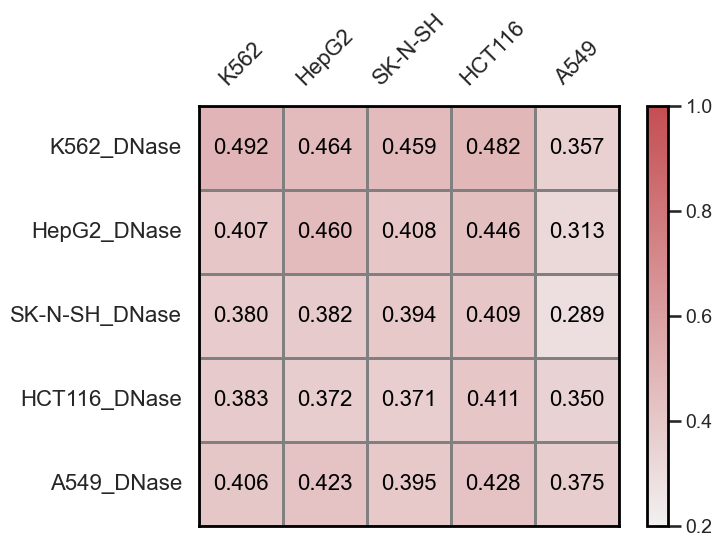

test
               K562  HepG2  SK-N-SH  HCT116  A549
K562_DNase    0.457  0.441    0.437   0.462 0.309
HepG2_DNase   0.367  0.425    0.368   0.416 0.253
SK-N-SH_DNase 0.340  0.346    0.361   0.385 0.216
HCT116_DNase  0.360  0.349    0.343   0.396 0.294
A549_DNase    0.374  0.405    0.365   0.410 0.318


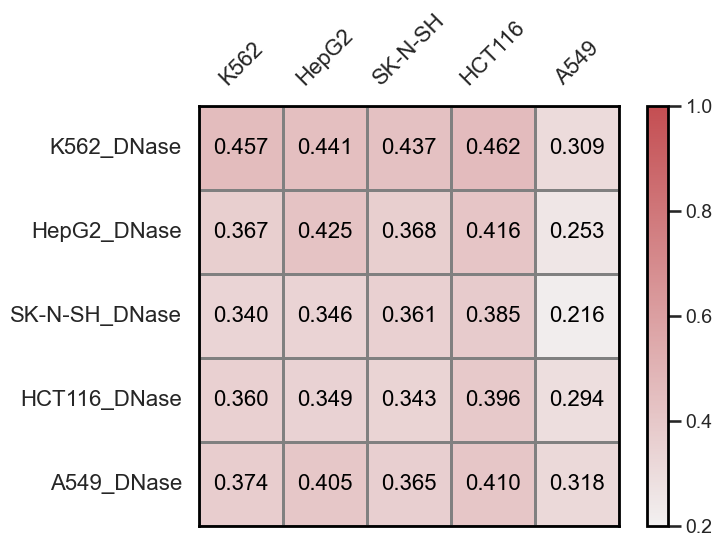

test+specific
               K562  HepG2  SK-N-SH  HCT116  A549
K562_DNase    0.383  0.253    0.216   0.345 0.174
HepG2_DNase   0.164  0.448    0.170   0.321 0.126
SK-N-SH_DNase 0.284  0.309    0.283   0.370 0.103
HCT116_DNase  0.362  0.352    0.339   0.341 0.362
A549_DNase    0.282  0.421    0.271   0.466 0.349


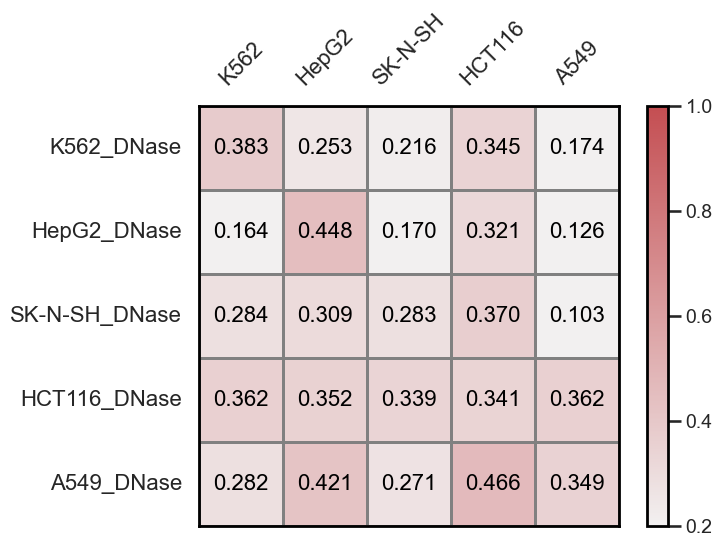

In [33]:
for data_split in ['total', 'test', 'test+specific']:
    pearson_df = pd.DataFrame()
    for c1 in cell_types:
        for c2 in cell_types:
            if data_split == 'specific':
                cond = data_split_dict[f'{c1}_specific']
            elif data_split == 'test+specific':
                cond = data_split_dict[f'{c1}_specific'] & data_split_dict['test']
            else:
                cond = data_split_dict[data_split]
            x = VEF_df.loc[cond, f'{c1}_DNase']
            y = MPRA_df.loc[cond, f'{c2}']
            r, p = pearson(x, y)
            pearson_df.loc[f'{c1}_DNase', f'{c2}'] = r
    # pearson_df.loc['HCT116', 'A549'] = np.nan
    # pearson_df.loc['A549', 'HCT116'] = np.nan
    pearson_df = pearson_df.astype(float)
    print(data_split)
    print(pearson_df)







    # === 图形配置 ===
    sns.set_theme(style="white", context="talk")  # 统一风格
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8)

    # === 热图绘制 ===
    sns_plot = sns.heatmap(
        pearson_df,
        cmap=sns.color_palette("light:r", as_cmap=True),
        vmin=0.2,
        vmax=1.0,
        square=True,
        annot=True,
        fmt=".3f",
        annot_kws={"size": 16, "color": "black"},
        cbar=True,
        linewidths=1,
        linecolor="gray",
        ax=ax
    )

    # === 坐标轴美化 ===
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.tick_params(axis="x", top=False, bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, rotation=0)

    # === 边框设置 ===
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor("black")

    # === 色条（colorbar）设置 ===
    cbar = sns_plot.collections[0].colorbar
    cbar.outline.set_linewidth(2)
    cbar.outline.set_edgecolor("black")
    cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
    cbar.ax.tick_params(labelsize=14)

    # === 输出 ===
    plt.savefig(f'figures/Gosai_MPRA_activity_vs_DNase_{data_split}_heatmap.png', dpi=400)
    plt.show()

In [8]:
VEF_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_VEF_zscore.tsv', sep='\t')

In [9]:
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']

In [10]:
# 初始化空 DataFrame，行是 assay，列是 cell types + 'All'
pearson_df = pd.DataFrame()

for assay in assays:
    pred_list = []
    true_list = []

    for cell_type in cell_types:
        pred = VEF_df[f'{cell_type}_{assay}']
        true = MPRA_df[cell_type]

        r, _ = pearson(pred, true)
        pearson_df.loc[cell_type, assay] = r

        pred_list.append(pred)
        true_list.append(true)

    # 合并后的相关性
    pred_all = np.concatenate(pred_list)
    true_all = np.concatenate(true_list)
    r, _ = pearson(pred_all, true_all)
    pearson_df.loc['All', assay] = r

pearson_df

after remove nan, len(x) < 2, pearson = nan
after remove nan, len(x) < 2, pearson = nan
after remove nan, len(x) < 2, pearson = nan
after remove nan, len(x) < 2, pearson = nan
after remove nan, len(x) < 2, pearson = nan
after remove nan, len(x) < 2, pearson = nan


,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
K562,0.535,0.483,0.487,0.195,0.406,0.361,0.335,0.400
HepG2,0.483,0.502,0.454,0.218,0.336,0.359,NaN,0.384
SK-N-SH,0.420,0.495,0.490,0.267,NaN,0.252,NaN,0.355
HCT116,0.483,0.500,0.500,0.336,0.483,0.334,NaN,0.376
A549,0.347,0.363,0.361,NaN,0.298,NaN,0.215,0.251
All,0.466,0.481,0.468,0.246,0.383,0.326,0.300,0.366


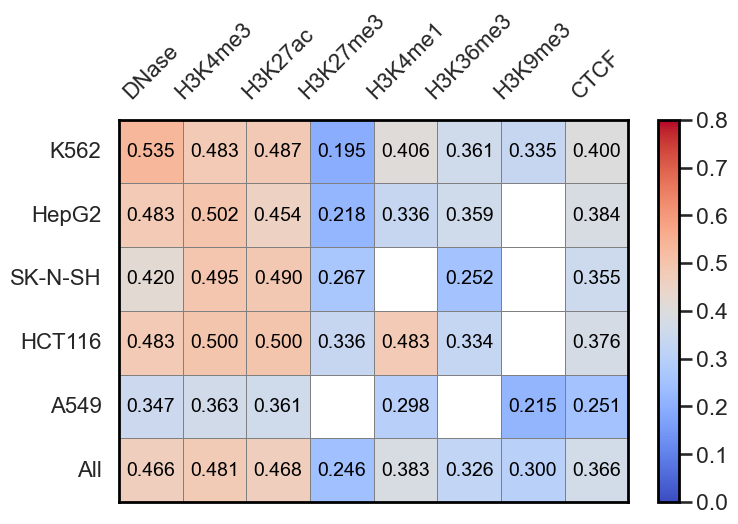

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# === 图形配置 ===
sns.set_theme(style="white", context="talk")
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8)

# === 创建与主图同高的 colorbar 轴 ===
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.3)  # pad 调整间距

# === 热图绘制 ===
sns_plot = sns.heatmap(
    pearson_df,
    cmap="coolwarm",
    vmin=0.0,
    vmax=0.8,
    square=True,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 14, "color": "black"},
    cbar=True,
    cbar_ax=cax,
    linewidths=0.5,
    linecolor="gray",
    ax=ax
)


# === 坐标轴美化 ===
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(axis="x", top=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, rotation=0)

# === 边框设置 ===
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor("black")

# === 色条（colorbar）设置 ===
cbar = sns_plot.collections[0].colorbar
cbar.outline.set_linewidth(2)
cbar.outline.set_edgecolor("black")

# === 输出 ===
plt.savefig('figures/Gosai_MPRA_VEFs_activity_heatmap.png', dpi=400)
plt.savefig('figures_pdf/Gosai_MPRA_VEFs_activity_heatmap.pdf', dpi=400)
plt.show()